# FEATURISATION & MODEL TUNING PROJECT

#### DOMAIN:  Semiconductor manufacturing process

#### CONTEXT:  
A  complex  modern  semiconductor  manufacturing  process  is  normally  under  constant  surveillance  via  the  monitoring  of signals/variables  collected  from  sensors  and  or  process  measurement  points.  However,  not  all  of  these  signals  are  equally  valuable  in  a specific  monitoring  system.  The  measured  signals  contain  a  combination  of  useful  information,  irrelevant  information  as  well  as  noise. Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs. These signals can be used as features to predict the yield type. And by analysing and trying out different combinations of features, essential signals that are impacting the yield type can be identified.
#### DATA DESCRIPTION: 
sensor-data.csv : (1567, 592)The data consists of 1567 datapoints each with 591 features. The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing. Target column “ –1” corresponds to a pass and “1” corresponds to a fail and the data time stamp is for that specific test point.
#### PROJECT  OBJECTIVE: 
We  will  build  a  classifier  to  predict  the  Pass/Fail  yield  of  a  particular  process  entity  and  analyse  whether  all  the features are required to build the model or not.

### Import  Libraries


In [1]:

# for basic operations
import numpy as np 
import pandas as pd 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# for modeling 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM

# to avoid warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


### Reading the Data and understanding the attributes

In [2]:
# reading the data
data = pd.read_csv('signal-data.csv')

# getting the shape of the data
# we have 1,567 rows and 592 columns from data description
print(data.shape)

(1567, 592)


Dataset contains 1567 rows and 592 columns

In [3]:
# getting the head of the data

data.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [4]:
data=data.drop(['Time'],axis=1)  #removing colunm "Time" as it is not essential for analysis
row, column = data.shape
print('The complete dataset contains', row, 'rows and', column, 'columns')

The complete dataset contains 1567 rows and 591 columns


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1561.0,3014.452896,73.621787,2743.2400,2966.260000,3011.4900,3056.6500,3356.3500
1,1560.0,2495.850231,80.407705,2158.7500,2452.247500,2499.4050,2538.8225,2846.4400
2,1553.0,2200.547318,29.513152,2060.6600,2181.044400,2201.0667,2218.0555,2315.2667
3,1553.0,1396.376627,441.691640,0.0000,1081.875800,1285.2144,1591.2235,3715.0417
4,1553.0,4.197013,56.355540,0.6815,1.017700,1.3168,1.5257,1114.5366
...,...,...,...,...,...,...,...,...
586,1566.0,0.021458,0.012358,-0.0169,0.013425,0.0205,0.0276,0.1028
587,1566.0,0.016475,0.008808,0.0032,0.010600,0.0148,0.0203,0.0799
588,1566.0,0.005283,0.002867,0.0010,0.003300,0.0046,0.0064,0.0286
589,1566.0,99.670066,93.891919,0.0000,44.368600,71.9005,114.7497,737.3048


* Mean and central value in most of the samples look to be more similar so almost the distribution is "normal"
* Relation between mean and standard deviation shows that data variation is less and more concentrated around the mean
* The spread of data is for the feature "4" looks to be more skewed as median vale=1.31, max=1114 leads to the possibility of skewness

In [6]:
#attribute type( except the target all the variables are float)
data.dtypes

0            float64
1            float64
2            float64
3            float64
4            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 591, dtype: object

In [7]:
# checking how many rows have missing values shows that all rows have atleast one missing value
rows=data.isnull().any(axis = 1).sum()
print( 'All the' ,rows,'rows have atleast one missing value')

All the 1567 rows have atleast one missing value


In [8]:
# replace the missing values in pima_df with mean value :Note, we do not need to specify the column names
# every column's missing value is replaced with that column's mean respectively
#pima_df=data
data = data.fillna(data.mean())

In [9]:
# checking how many rows have missing values shows that all rows have atleast one missing value
rows=data.isnull().any(axis = 1).sum()
print( 'All the' ,rows,'rows have atleast one missing value')

All the 0 rows have atleast one missing value


All the missing values were replaced with mean value

### Data Visualization

In [10]:
unique_vals = data['Pass/Fail'].unique()  # [0, 1, 2]
#print(unique_vals)
targets = [data.loc[data['Pass/Fail'] == val] for val in unique_vals]
#print(targets)

C:\Users\udhay\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\udhay\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\udhay\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\udhay\anaconda3\lib\site-packages\seaborn\distr

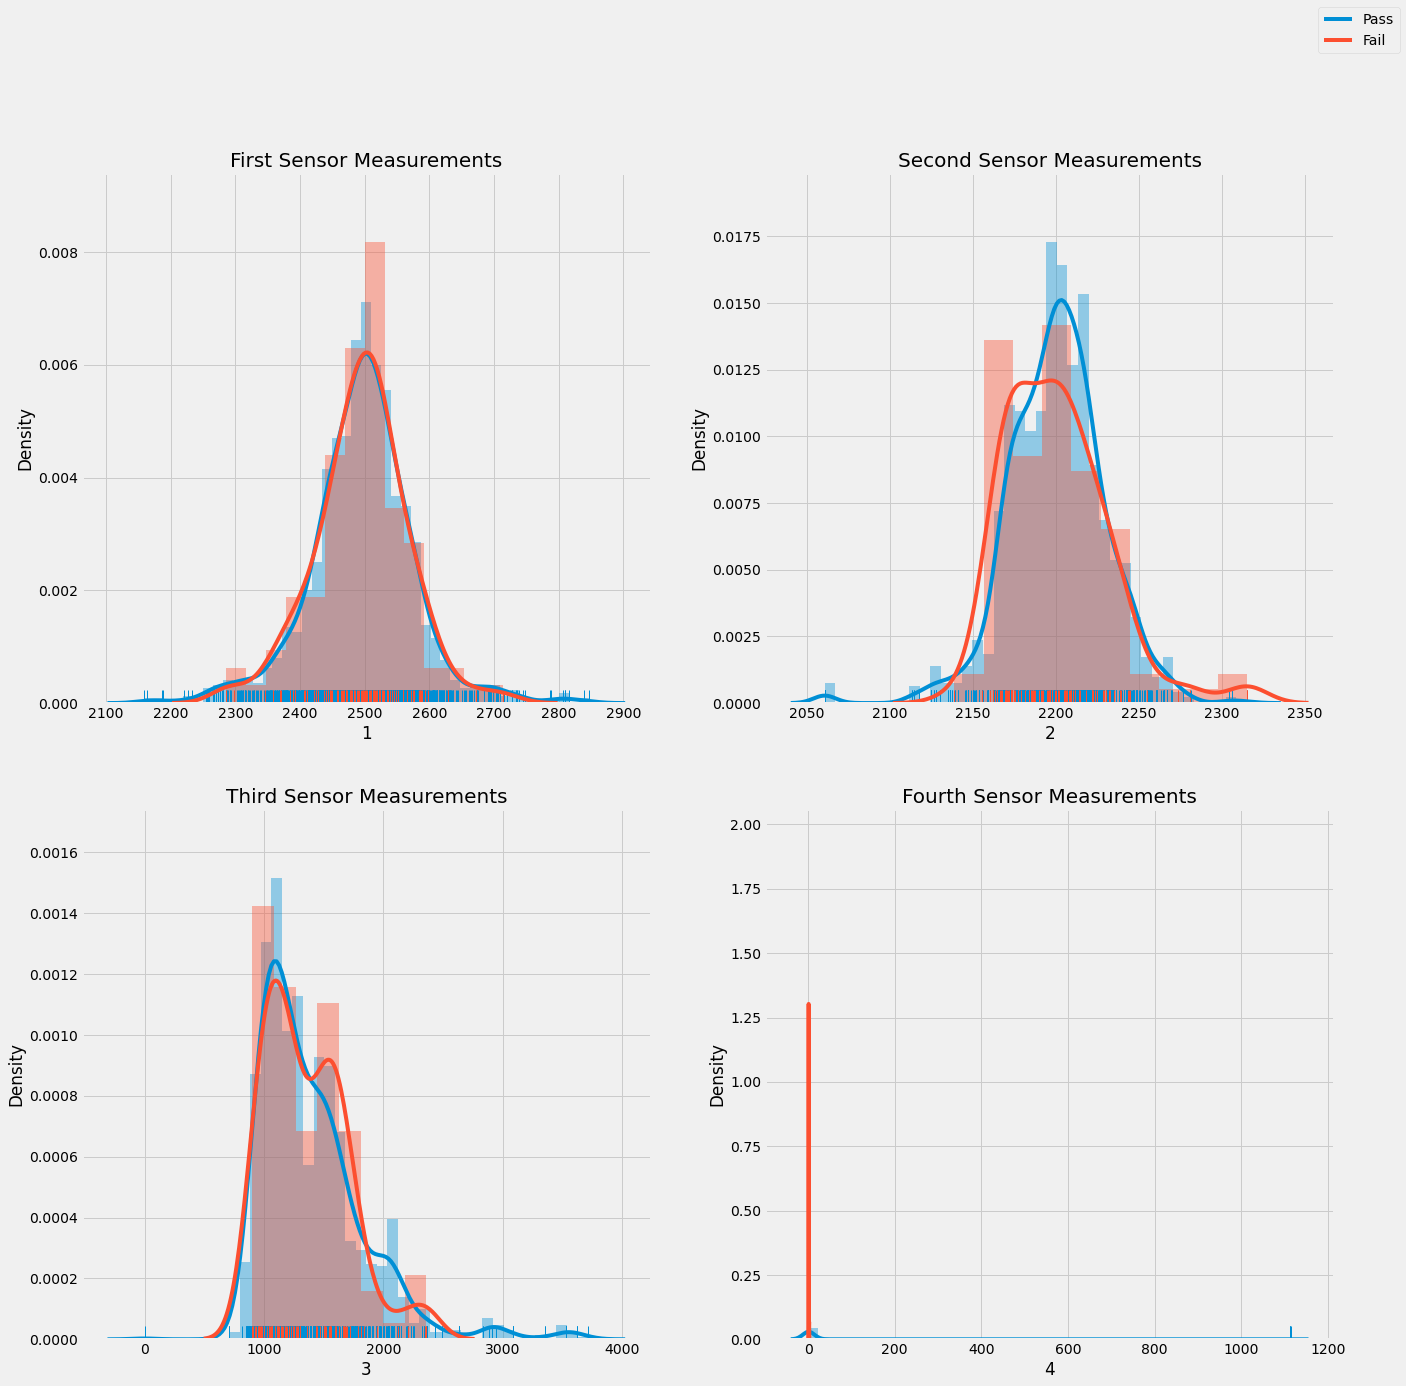

In [11]:
fig = plt.figure(figsize=(20,20))

plt.subplot(2, 2, 1)
for target in targets:
    sns.distplot(target['1'], hist=True, rug=True)
plt.title('First Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 2)
for target in targets:
    sns.distplot(target['2'], hist=True, rug=True)
plt.title('Second Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 3)
for target in targets:
    sns.distplot(target['3'], hist=True, rug=True)
plt.title('Third Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 4)
for target in targets:
    sns.distplot(target['4'], hist=True, rug=True)
plt.title('Fourth Sensor Measurements', fontsize = 20)

#sns.add_legend()
#plt.legend()
fig.legend(labels=['Pass','Fail'])
plt.show()

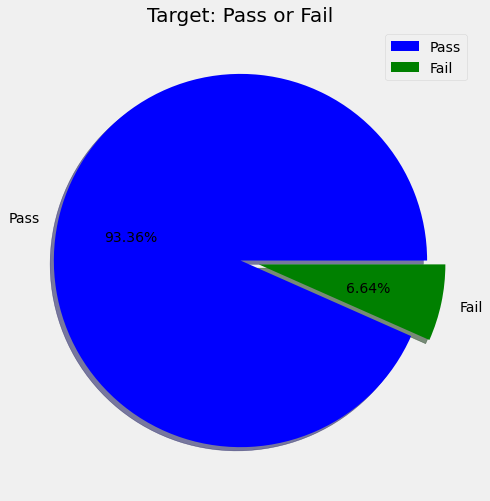

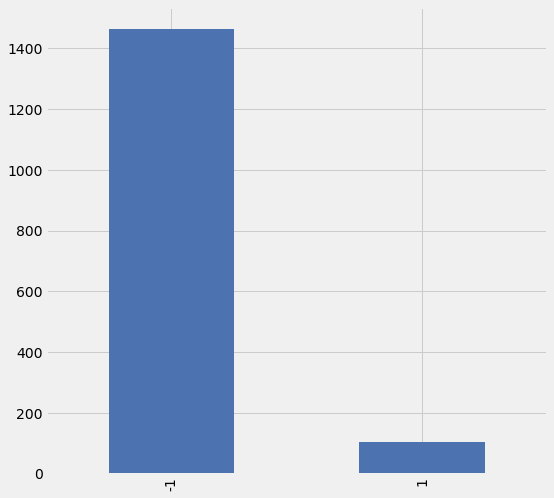

In [12]:
# pie chart
# We have highly imbalanced class with only 6.6% failures and 93.4% pass

labels = ['Pass', 'Fail']
size = data['Pass/Fail'].value_counts()
colors = ['blue', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
data['Pass/Fail'].value_counts().plot(kind="bar");

In dataset, the predicted outcomes were of 93.36% Pass and 6.64% Fail

Text(0.5, 1.0, 'Correlation heatmap for the Data')

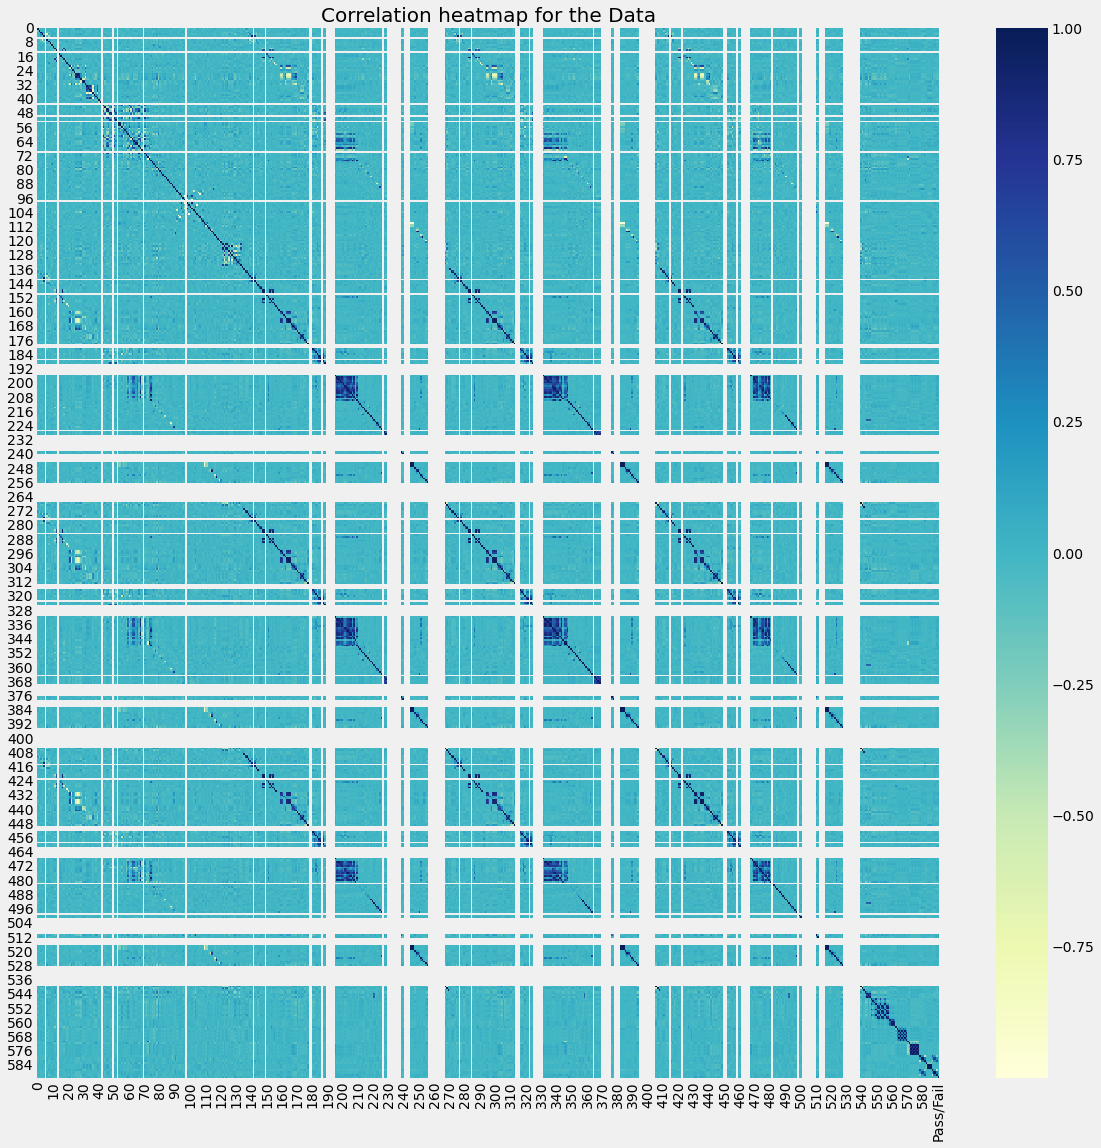

In [13]:
# heatmap to get correlation

plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(data.corr(), cmap = "YlGnBu")
plt.title('Correlation heatmap for the Data', fontsize = 20)

### Data Cleaning/Preprocessing

In [14]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    
# Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [15]:
#Remove columns having more than 70% correlation
#Both positive and negative correlations are considered here
data = remove_collinear_features(data,0.70)

17 | 11 | 0.79
22 | 21 | 0.73
26 | 25 | 0.82
27 | 25 | 0.98
27 | 26 | 0.79
30 | 29 | 0.86
34 | 32 | 0.75
35 | 34 | 0.77
36 | 32 | 0.75
36 | 34 | 1.0
36 | 35 | 0.77
39 | 34 | 0.8
39 | 36 | 0.8
46 | 45 | 0.81
50 | 46 | 0.9
51 | 47 | 0.71
54 | 53 | 0.94
60 | 43 | 0.9
60 | 50 | 0.7
65 | 64 | 0.84
66 | 46 | 0.82
66 | 50 | 0.76
70 | 46 | 0.8
70 | 50 | 0.77
70 | 62 | 0.73
70 | 66 | 0.9
73 | 72 | 0.84
96 | 94 | 0.96
98 | 94 | 0.84
98 | 96 | 0.87
101 | 94 | 0.73
101 | 96 | 0.79
101 | 98 | 0.91
104 | 99 | 0.99
105 | 92 | 0.99
106 | 93 | 0.99
123 | 121 | 0.94
124 | 121 | 0.89
124 | 123 | 0.86
125 | 122 | 0.71
127 | 122 | 0.96
130 | 122 | 0.83
130 | 127 | 0.79
140 | 4 | 1.0
147 | 16 | 0.89
148 | 16 | 0.97
148 | 147 | 0.89
152 | 16 | 0.98
152 | 147 | 0.9
152 | 148 | 0.99
154 | 16 | 0.87
154 | 147 | 0.8
154 | 148 | 0.94
154 | 152 | 0.89
155 | 19 | 0.81
163 | 26 | 0.71
163 | 159 | 0.76
164 | 26 | 0.77
164 | 159 | 0.8
164 | 163 | 0.92
165 | 26 | 0.74
165 | 159 | 0.79
165 | 163 | 0.9
165 | 164 | 0.96
1

431 | 294 | 0.72
431 | 295 | 0.83
431 | 298 | 0.83
431 | 299 | 0.85
431 | 300 | 0.82
431 | 430 | 0.9
434 | 26 | 0.82
434 | 159 | 0.71
434 | 163 | 0.88
434 | 164 | 0.9
434 | 165 | 0.86
434 | 294 | 0.75
434 | 298 | 0.89
434 | 299 | 0.89
434 | 300 | 0.86
434 | 430 | 0.95
434 | 431 | 0.93
435 | 26 | 0.83
435 | 159 | 0.71
435 | 163 | 0.84
435 | 164 | 0.91
435 | 165 | 0.87
435 | 294 | 0.75
435 | 298 | 0.86
435 | 299 | 0.9
435 | 300 | 0.86
435 | 430 | 0.95
435 | 431 | 0.93
435 | 434 | 0.99
436 | 26 | 0.81
436 | 159 | 0.71
436 | 163 | 0.84
436 | 164 | 0.9
436 | 165 | 0.88
436 | 294 | 0.75
436 | 298 | 0.86
436 | 299 | 0.9
436 | 300 | 0.87
436 | 430 | 0.95
436 | 431 | 0.93
436 | 434 | 0.99
436 | 435 | 1.0
437 | 166 | 0.99
437 | 301 | 0.95
439 | 168 | 0.79
439 | 303 | 0.77
440 | 27 | 0.71
440 | 169 | 1.0
440 | 304 | 0.98
441 | 170 | 0.99
441 | 305 | 0.95
442 | 171 | 0.97
442 | 306 | 0.96
443 | 172 | 1.0
443 | 174 | 1.0
443 | 307 | 0.96
443 | 309 | 0.96
444 | 173 | 0.99
444 | 308 | 0.95
445 | 172 

In [16]:
# separating the dependent and independent data

x = data.iloc[:,:306]
y = data["Pass/Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 306)
shape of y: (1567,)


In [17]:
# splitting them into train test and split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

# gettiing the shapes
print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1096, 306)
shape of x_test:  (471, 306)
shape of y_train:  (1096,)
shape of y_test:  (471,)


In [18]:
# standardization

from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# fitting independent data to the model
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## XGBoost Algorithm (Normal data)

In [19]:
model = XGBClassifier(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

C:\Users\udhay\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:>

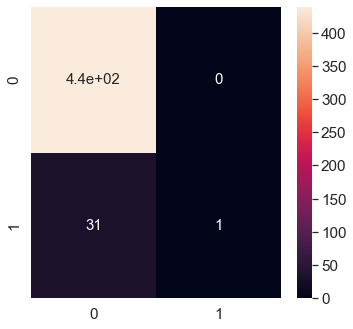

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [21]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  93.41825902335457


In the failure class we have only 1 observation classified correctly for XGBoost but still has 93.42% accuracy as we predicted correctly on the observations that passed

### Random Forest Classifier (Normal Data)

In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

<AxesSubplot:>

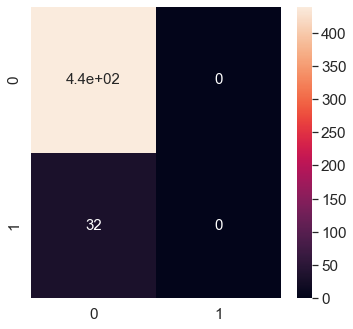

In [23]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [24]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  93.20594479830149


In the failure class we have no observation classified correctly for Random Forest but still has 93.21% accuracy as we predicted correctly on the observations that passed

### Logistic Regression (Normal Data)

In [25]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train, y_train) 
y_pred = lr.predict(x_test)

<AxesSubplot:>

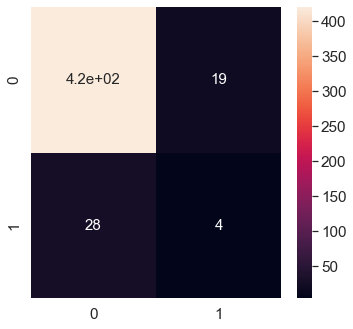

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [27]:
print("Accuracy: ", lr.score(x_test,y_test)*100)

Accuracy:  90.02123142250531


In the failure class we have 4 observation classified correctly for logistic regression and 90% accuracy as we predicted correctly on the observations that passed. So even though this model has lesser accuracy it is preferable over previous models as at least it is classifying more observations in the failure class correctly

### Lasso (Normal Data)

In [28]:
lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train,y_train)
#print ("Lasso model:", (lasso.coef_))

y_pred = lasso.predict(x_test)

#Convert the sign of the predicted values as the classifier
y_pred2 = np.sign(y_pred)

In [29]:
print("Accuracy: ", lasso.score(x_test,y_test)*100)

Accuracy:  -0.007974076019068299


<AxesSubplot:>

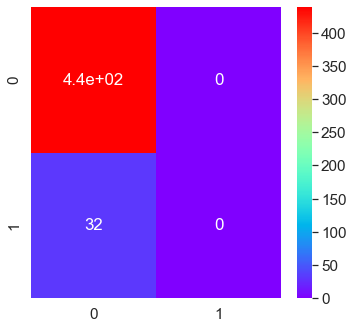

In [30]:
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

### UnderSampling of the Dataset

In [31]:
# Under Sampling - Check how many failure observations are there
# We have 104 such observations

failed_tests = np.array(data[data['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

104


In [32]:
# Check how many pass observations are there
# We have 1,463 such observations

normal_indices = data[data['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

1463


In [33]:
# Get 104 random observations from the pass class as well

random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

104


In [34]:
#Getting a 50-50 representation from both pass and fail classes
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [35]:
# creating the undersample data

undersample_data = data.iloc[under_sample, :]

In [36]:
# splitting the undersample dataset into x and y sets

x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 330)
(208, 1)


In [37]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 330)
(145, 1)
(63, 330)
(63, 1)


In [38]:
# standardization

sc = StandardScaler()
x_train_us = sc.fit_transform(x_train_us)
x_test_us = sc.transform(x_test_us)
x_train_us.shape
x_test_us.shape

(63, 330)

### Xg-Boost Classifier (Undersampling)

In [39]:
model = XGBClassifier(random_state=1)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)


C:\Users\udhay\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:55:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Confusion Matrix after UnderSampling with XgBoost

<AxesSubplot:>

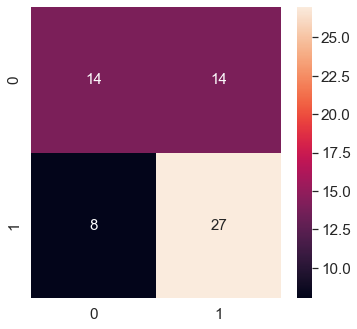

In [40]:
cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})



In [41]:
print("Accuracy: ", model.score(x_test_us,y_test_us)*100)

Accuracy:  65.07936507936508


### Grid Search - XG Boost (Undersampling

In [42]:
# Applying Grid Search CV to find the best model with the best parameters



parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy',  n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

C:\Users\udhay\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:55:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:55:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [43]:
print("Best Accuracy: ", best_accuracy*100)
print("Best Parameter: ", best_parameters)

Best Accuracy:  66.89655172413794
Best Parameter:  {'cv': 2, 'max_depth': 6, 'random_state': 1}


In [44]:
weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

[21:55:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:55:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [45]:
print("Accuracy: ", model.score(x_train_us, y_train_us)*100)

Accuracy:  100.0


### Confusion matrix XG Boost - Grid Search (Undersample)

<AxesSubplot:>

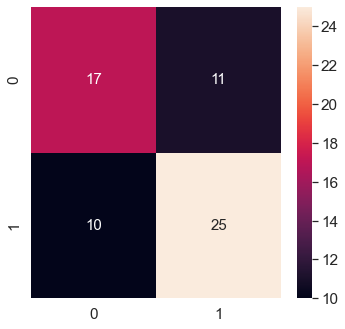

In [46]:
cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

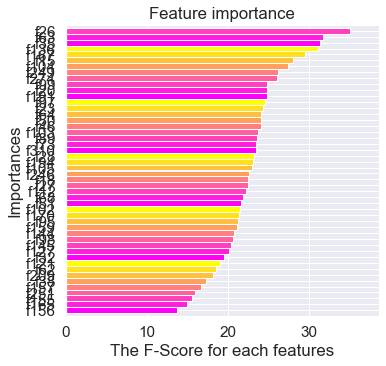

In [47]:
# plotting the feature importances

colors = plt.cm.spring(np.linspace(0, 1, 9))
xgb.plot_importance(model, height = 1, color = colors, grid = True, importance_type = 'cover', show_values = False)

plt.rcParams['figure.figsize'] = (100, 100)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.show()

### Over-Sampling with SMOTE

In [48]:
x_resample, y_resample  = SMOTE(random_state=1).fit_sample(x, y.values.ravel())

print(x_resample.shape)
print(y_resample.shape)

AttributeError: 'SMOTE' object has no attribute 'fit_sample'

In [49]:
x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_os.shape)
print(y_train_os.shape)
print(x_test_os.shape)
print(y_test_os.shape)

(145, 330)
(145, 1)
(63, 330)
(63, 1)


In [50]:
# standardization



sc = StandardScaler()
x_train_os = sc.fit_transform(x_train_os)
x_test_os = sc.transform(x_test_os)

#### Xg-Boost Classifier - Grid Search (Oversampling)

In [51]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=1)

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)

C:\Users\udhay\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:56:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [52]:
# Applying Grid Search CV to find the best model with the best parameters

from sklearn.model_selection import GridSearchCV

# making a parameters list
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

# making a grid search model
grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train_os, y_train_os)

# getting the results
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

C:\Users\udhay\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:56:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [53]:
print("Best Accuracy: ", best_accuracy)
print("Best Parameter: ", best_parameters)

Best Accuracy:  0.6689655172413793
Best Parameter:  {'cv': 2, 'max_depth': 6, 'random_state': 1}


In [54]:
weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)

[21:56:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Confusion Matrix after OverSampling with XgBoost

<AxesSubplot:>

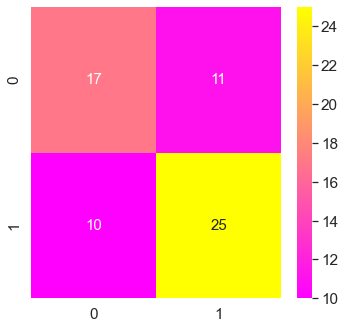

In [55]:
cm = confusion_matrix(y_test_os, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15}, cmap = 'spring')

In [56]:
print("Accuracy: ", model.score(x_test_os,y_test_os)*100)

Accuracy:  66.66666666666666


### Random Forest (Oversampling)

In [57]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_os, y_train_os)
#scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test_os)
print("Accuracy: ", model.score(x_test_os,y_test_os)*100)

C:\Users\udhay\AppData\Local\Temp/ipykernel_17160/3958726046.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train_os, y_train_os)


Accuracy:  58.730158730158735


### Random Forest - (Oversampled) - Confusion Matrix

<AxesSubplot:>

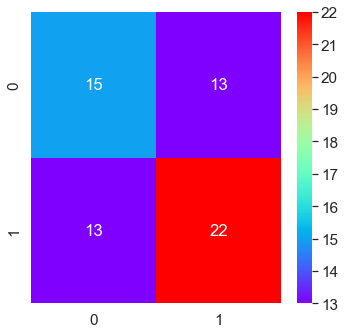

In [58]:
# printing the confusion matrix
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

### Logistic regression - (Oversampled

In [59]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_os, y_train_os) 
y_pred = lr.predict(x_test_os)

print("Accuracy: ", lr.score(x_test_os,y_test_os)*100)

Accuracy:  61.904761904761905


C:\Users\udhay\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Logistic regression (Oversampled) - Confusion matrix

<AxesSubplot:>

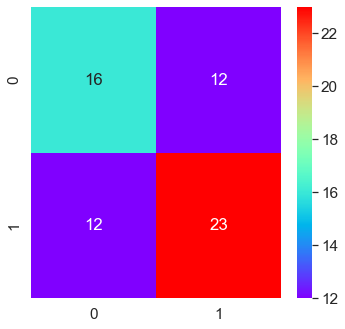

In [60]:
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

### Random Forest - (Undersampled)

In [61]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_us, y_train_us)
#scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test_us)

C:\Users\udhay\AppData\Local\Temp/ipykernel_17160/4010899696.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train_us, y_train_us)


#### Confusion Matrix for Random Forest (Undersampled)

<AxesSubplot:>

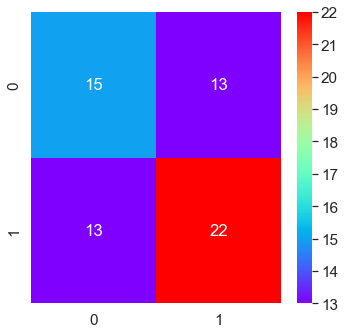

In [62]:
# evaluating the model

# printing the confusion matrix
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [63]:
print("Accuracy: ", model.score(x_test_us,y_test_us)*100)

Accuracy:  58.730158730158735


### Using Lasso (Undersampled)

In [64]:
lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train_us,y_train_us)
#print ("Lasso model:", (lasso.coef_))

Lasso(alpha=0.1, random_state=1)

In [65]:
y_pred = lasso.predict(x_test_us)

In [66]:
print(y_pred)

[-0.77626433  0.30595703 -0.47252671 -0.15401872  0.02219825 -0.06422558
 -0.61422418  0.10909875 -0.31297713  0.13488247  0.50457082 -0.25010142
 -0.42325313  0.2767784  -0.59513595 -0.06422558 -0.07888049 -0.17987939
  0.44246695  0.00926688 -0.11399879  0.31940405  0.39180764  0.13138049
 -0.07670692  0.50945339 -0.04323649  0.2328175   0.33150549  0.31391166
 -0.13347342  0.33681874  0.00594513 -0.07988824  0.04020027  0.08948233
 -0.03154258  0.17665228 -0.08381759 -0.09171358  0.15439946  0.02511935
  0.30370907 -0.09084386  0.3513902   0.07545836  0.22222209  0.58239302
 -0.18643164 -0.15425221 -0.43302489  0.2043934   0.00376476  0.19582171
 -0.05697631 -0.24529856  0.21480533  0.08200614  0.20529629 -0.10162129
 -0.46015177  0.48249773  0.27405055]


In [67]:
print(y_test_us)

      Pass/Fail
726          -1
1279         -1
497          -1
1148         -1
495           1
...         ...
1302          1
273           1
691          -1
12           -1
441           1

[63 rows x 1 columns]


In [68]:
#Convert the sign of the predicted values as the classifier
y_pred2 = np.sign(y_pred)

#### Confusion matrix for Lasso (Undersampled)

<AxesSubplot:>

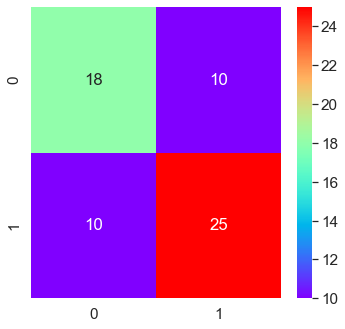

In [69]:
cm = confusion_matrix(y_test_us, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [70]:
print("Accuracy: ", lasso.score(x_test_us,y_test_us)*100)

Accuracy:  12.913488944785168


### Logistic Regression (Undersampled)

In [71]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_us, y_train_us)

C:\Users\udhay\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=1)

In [72]:
y_pred = lr.predict(x_test_us)

### Confusion matrix for Logistic Regression (Undersampled)

<AxesSubplot:>

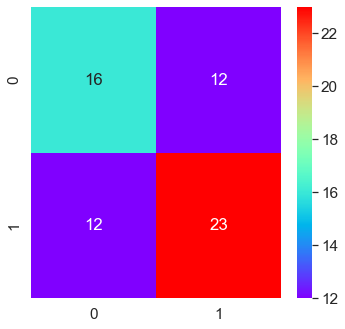

In [73]:
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [74]:
print("Accuracy: ", lr.score(x_test_us,y_test_us)*100)

Accuracy:  61.904761904761905


### One Class SVM (Undersampled)

In one-class SVM, the support vector model is trained on data that has only one class, which is the “normal” class. It infers the properties of normal cases and from these properties can predict which examples are unlike the normal examples. This is useful for anomaly detection because the scarcity of training examples is what defines anomalies: that is, typically there are very few examples of the network intrusion, fraud, or other anomalous behavior.

In [75]:
model = OneClassSVM(kernel ='rbf', degree=3, gamma=0.1,nu=0.005, max_iter=-1)

model.fit(x_train_us, y_train_us)
y_pred = model.fit_predict(x_test_us)

### Confusion Matrix for One Class SVM

<AxesSubplot:>

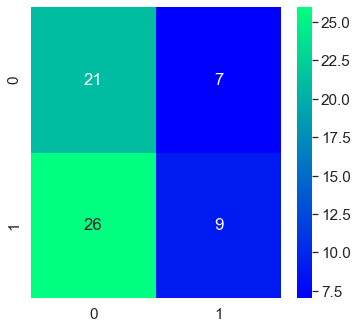

In [76]:
# evaluating the model
# printing the confusion matrix
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm ,annot = True, cmap = 'winter')

In [77]:
#print("Accuracy: ", model.score(x_test_us,y_test_us)*100)
print(accuracy_score(x_test_us,y_test_us))
#print("Accuracy: ", score_samples(x_test_us,y_test_us)*100)


NameError: name 'accuracy_score' is not defined

### OneClassSVM - (Oversampled)

In [78]:
model = OneClassSVM(kernel ='rbf', degree=3, gamma=0.1,nu=0.005, max_iter=-1)

model.fit(x_train_os, y_train_os)
y_pred = model.fit_predict(x_test_os)

### Confusion matrix for OneClassSVM - (Oversampled)

<AxesSubplot:>

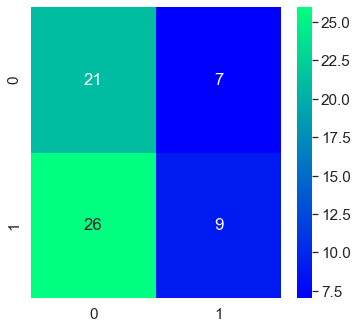

In [79]:
# evaluating the model
# printing the confusion matrix
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm ,annot = True, cmap = 'winter')

### Using PCA for demensionality reduction

In [80]:
#Scaling the data before applying PCA
from scipy.stats import zscore
data_new=data.iloc[:,:306].apply(zscore)
data_new.head()

,0,1,2,3,4,5,6,7,8,9,...,529,530,531,532,533,534,535,536,537,538
0,0.224309,0.849725,-0.436273,0.033555,-0.050580,NaN,-0.563790,0.266269,0.509826,1.128417,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.107136,-0.382910,1.017137,0.153067,-0.060045,NaN,0.198217,0.322244,0.456999,0.022582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.114158,0.799102,-0.481289,0.686213,-0.047906,NaN,-0.906210,0.255074,-0.260907,0.327183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.350312,-0.198875,-0.051547,-1.106948,-0.051290,NaN,0.503246,-0.013602,0.343218,-0.765408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.242143,0.087526,1.117387,-0.158919,-0.047492,NaN,-0.115382,0.187905,0.545044,-0.149584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
data_new.isnull().any().any()

True

In [82]:
data_new = data_new.replace(np.NaN, 0)

In [83]:
data_new.isnull().any().any()

False

In [84]:
# separating the dependent and independent data

x = data_new.iloc[:,:306]
y = data["Pass/Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 306)
shape of y: (1567,)


In [85]:
# PCA
# Step 1 - Create covariance matrix

cov_matrix = np.cov(x.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00063857 -0.14393166  0.00475868 ...  0.          0.
   0.        ]
 [-0.14393166  1.00063857  0.00577089 ...  0.          0.
   0.        ]
 [ 0.00475868  0.00577089  1.00063857 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [86]:
# Step 2- Get eigen values and eigen vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[ 0.05128271  0.01493216  0.03242379 ...  0.          0.
   0.        ]
 [-0.00292356  0.01393595 -0.03131617 ...  0.          0.
   0.        ]
 [-0.01396042  0.00843125 -0.07668491 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]

 Eigen Values 
%s [7.02530982e+00 4.83681262e+00 3.89922539e+00 3.68482645e+00
 3.39569186e+00 3.10727369e+00 3.01166054e+00 2.81731463e+00
 2.60049958e+00 2.51767101e+00 2.48344098e+00 2.41895037e+00
 2.33448498e+00 2.04321800e-04 2.23849448e+00 2.16808795e+00
 2.14422796e+00 2.10302928e+00 2.06073558e+00 2.03241374e+00
 1.98749409e+00 1.96952756e+00 1.91685030e+00 1.90013868e+00
 1.86157663e+00 1.83196068e+00 1.80561142e+00 1.78651988e+00
 1.74041905e+00 1.76158317e+00 1.72710597e+00 1.70245799e+00
 1.67065831e+00 1.64242279e+00 

In [87]:
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

Cumulative Variance Explained [  3.69517186   6.23923815   8.29015239  10.22829709  12.01436281
  13.64872636  15.23279931  16.71465022  18.08246076  19.40670515
  20.71294522  21.98526453  23.21315674  24.39055988  25.5309306
  26.65875144  27.7649026   28.84880812  29.91781693  30.9631989
  31.99913084  33.0073556   34.00679038  34.98594229  35.94951682
  36.89923216  37.83890573  38.7654631   39.68088856  40.58931161
  41.48477032  42.36350304  43.22738444  44.07143511  44.90831882
  45.72155947  46.5299415   47.33416133  48.11707732  48.89293189
  49.6572921   50.41776683  51.16379269  51.88638783  52.60029783
  53.31130646  54.0138849   54.70923834  55.39815841  56.0713205
  56.73209017  57.38647889  58.03433689  58.67496739  59.30571038
  59.9297484   60.54382132  61.15584901  61.76098154  62.35979713
  62.9490647   63.53412918  64.11480626  64.68840247  65.25613318
  65.82220593  66.37994049  66.93226973  67.47110575  68.00753919
  68.54184341  69.07136199  69.5946904   70.10780

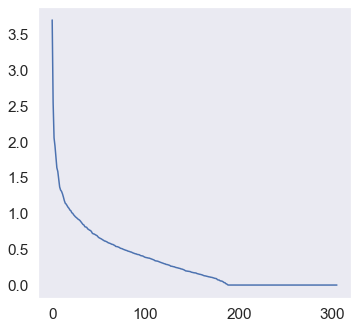

In [88]:
plt.plot(var_exp)

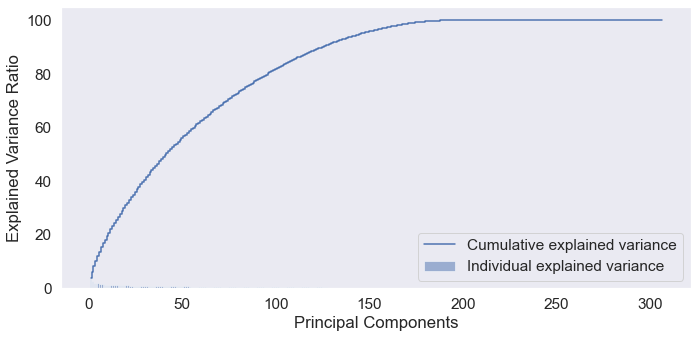

In [89]:
# Ploting 
plt.figure(figsize=(10 , 5))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [90]:
len(cum_var_exp)

306

In [91]:
# Using scikit learn PCA here. It does all the above steps and maps data to PCA dimensions in one shot
from sklearn.decomposition import PCA

# NOTE - we are generating only 130 PCA dimensions (dimensionality reduction from 306 to 130)
# For 130 components we are getting approximately 90% of the variance
pca = PCA(n_components=130)
data_reduced = pca.fit_transform(x)
data_reduced.transpose()

array([[ 3.30532011,  1.17888677,  1.67171496, ..., -1.96680855,
        -2.16505201, -2.70804997],
       [-1.3026456 , -1.86250132, -0.22004857, ..., -0.91376304,
        -0.66159678,  1.94668217],
       [-0.57247336, -0.04886957,  2.55793318, ..., -1.28874442,
         1.94497721,  2.31105529],
       ...,
       [ 0.58467892,  0.67236785, -0.48704953, ...,  0.2016032 ,
        -0.27862755, -0.11282975],
       [-1.43568485,  0.51330307,  0.06060412, ..., -0.37870953,
         0.15051052,  0.66264334],
       [-1.31490313,  0.16120008, -0.82371467, ...,  0.60448212,
         0.16717648,  0.2522136 ]])

In [92]:
pca.components_

array([[-0.05128275,  0.00292357,  0.01396038, ..., -0.        ,
        -0.        , -0.        ],
       [-0.01493247, -0.01393559, -0.0084308 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03242382,  0.0313156 ,  0.07668445, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [ 0.07618445,  0.0779016 , -0.06651797, ..., -0.        ,
        -0.        , -0.        ],
       [ 0.04124075,  0.01627402,  0.00423078, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05889236, -0.04545924,  0.03655539, ...,  0.        ,
         0.        ,  0.        ]])

In [93]:
df_comp = pd.DataFrame(pca.components_,columns=list(x))
df_comp.head()

,0,1,2,3,4,5,6,7,8,9,...,529,530,531,532,533,534,535,536,537,538
0,-0.051283,0.002924,0.013960,-0.084844,-0.025989,-0.000000e+00,0.099471,0.021914,0.079191,-0.034482,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,-0.014932,-0.013936,-0.008431,-0.040634,0.015514,0.000000e+00,0.046771,-0.027014,0.003939,-0.009611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.032424,0.031316,0.076684,0.017890,0.043678,-5.551115e-17,-0.020586,-0.045058,-0.038699,-0.017404,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,-0.012033,0.007206,-0.073612,-0.021989,-0.004697,1.110223e-16,0.010729,0.032760,0.028868,-0.038001,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,0.025038,0.011254,0.067693,0.040650,0.051864,2.220446e-16,-0.056175,-0.042246,0.052315,-0.005765,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


<AxesSubplot:>

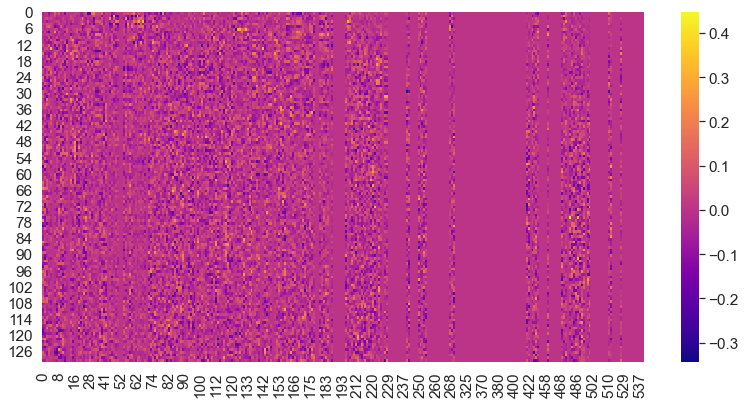

In [94]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma')

In [95]:
data_reduced.shape

(1567, 130)

In [96]:
df_red2 = pd.DataFrame(data_reduced)
df_red2.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,3.305320,-1.302646,-0.572473,-0.465905,-1.152133,-0.179024,1.404290,2.795337,-0.129353,-4.066474,...,0.277037,0.507996,0.674469,0.071570,0.217210,0.454732,-0.429839,0.584679,-1.435685,-1.314903
1,1.178887,-1.862501,-0.048870,-0.947456,-0.004463,-0.212486,0.367076,3.162302,-0.257858,-0.983465,...,0.247271,0.112573,-0.820438,-0.394616,0.563538,0.883425,-1.106553,0.672368,0.513303,0.161200
2,1.671715,-0.220049,2.557933,0.472106,-1.303334,-0.937886,-0.036023,1.820358,0.067959,-0.959292,...,-0.413015,0.651715,1.367663,-0.365178,-1.065831,0.583126,0.209664,-0.487050,0.060604,-0.823715
3,3.211645,-0.459513,2.934530,-0.221462,-1.661202,-1.352623,-1.275621,0.597136,-0.910076,1.858499,...,-0.372189,0.230333,0.677495,-1.313027,0.354069,-0.900151,-0.501653,1.051884,0.425743,-0.240354
4,2.168051,2.178167,2.033165,0.629773,2.116970,0.793363,0.597911,0.596086,-2.185775,-1.141325,...,-0.062552,0.099175,-0.629101,-1.309235,-0.447845,0.651844,-1.139022,-0.426897,1.661448,0.162292


In [97]:
df_red3 = df_red2.copy()
df_red4 = df_red3
df_red4["Pass/Fail"] = data["Pass/Fail"]

In [98]:
df_red4.head()

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,Pass/Fail
0,3.305320,-1.302646,-0.572473,-0.465905,-1.152133,-0.179024,1.404290,2.795337,-0.129353,-4.066474,...,0.507996,0.674469,0.071570,0.217210,0.454732,-0.429839,0.584679,-1.435685,-1.314903,-1
1,1.178887,-1.862501,-0.048870,-0.947456,-0.004463,-0.212486,0.367076,3.162302,-0.257858,-0.983465,...,0.112573,-0.820438,-0.394616,0.563538,0.883425,-1.106553,0.672368,0.513303,0.161200,-1
2,1.671715,-0.220049,2.557933,0.472106,-1.303334,-0.937886,-0.036023,1.820358,0.067959,-0.959292,...,0.651715,1.367663,-0.365178,-1.065831,0.583126,0.209664,-0.487050,0.060604,-0.823715,1
3,3.211645,-0.459513,2.934530,-0.221462,-1.661202,-1.352623,-1.275621,0.597136,-0.910076,1.858499,...,0.230333,0.677495,-1.313027,0.354069,-0.900151,-0.501653,1.051884,0.425743,-0.240354,-1
4,2.168051,2.178167,2.033165,0.629773,2.116970,0.793363,0.597911,0.596086,-2.185775,-1.141325,...,0.099175,-0.629101,-1.309235,-0.447845,0.651844,-1.139022,-0.426897,1.661448,0.162292,-1


In [99]:
df_red4.shape

(1567, 131)

In [100]:
#Causing system crash and taking too much time, so commented out
#sns.pairplot(df_red4,diag_kind='kde')

array([[<AxesSubplot:title={'center':'0'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'1'}, xlabel='Pass/Fail'>],
       [<AxesSubplot:title={'center':'2'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'3'}, xlabel='Pass/Fail'>],
       [<AxesSubplot:title={'center':'4'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'5'}, xlabel='Pass/Fail'>]],
      dtype=object)

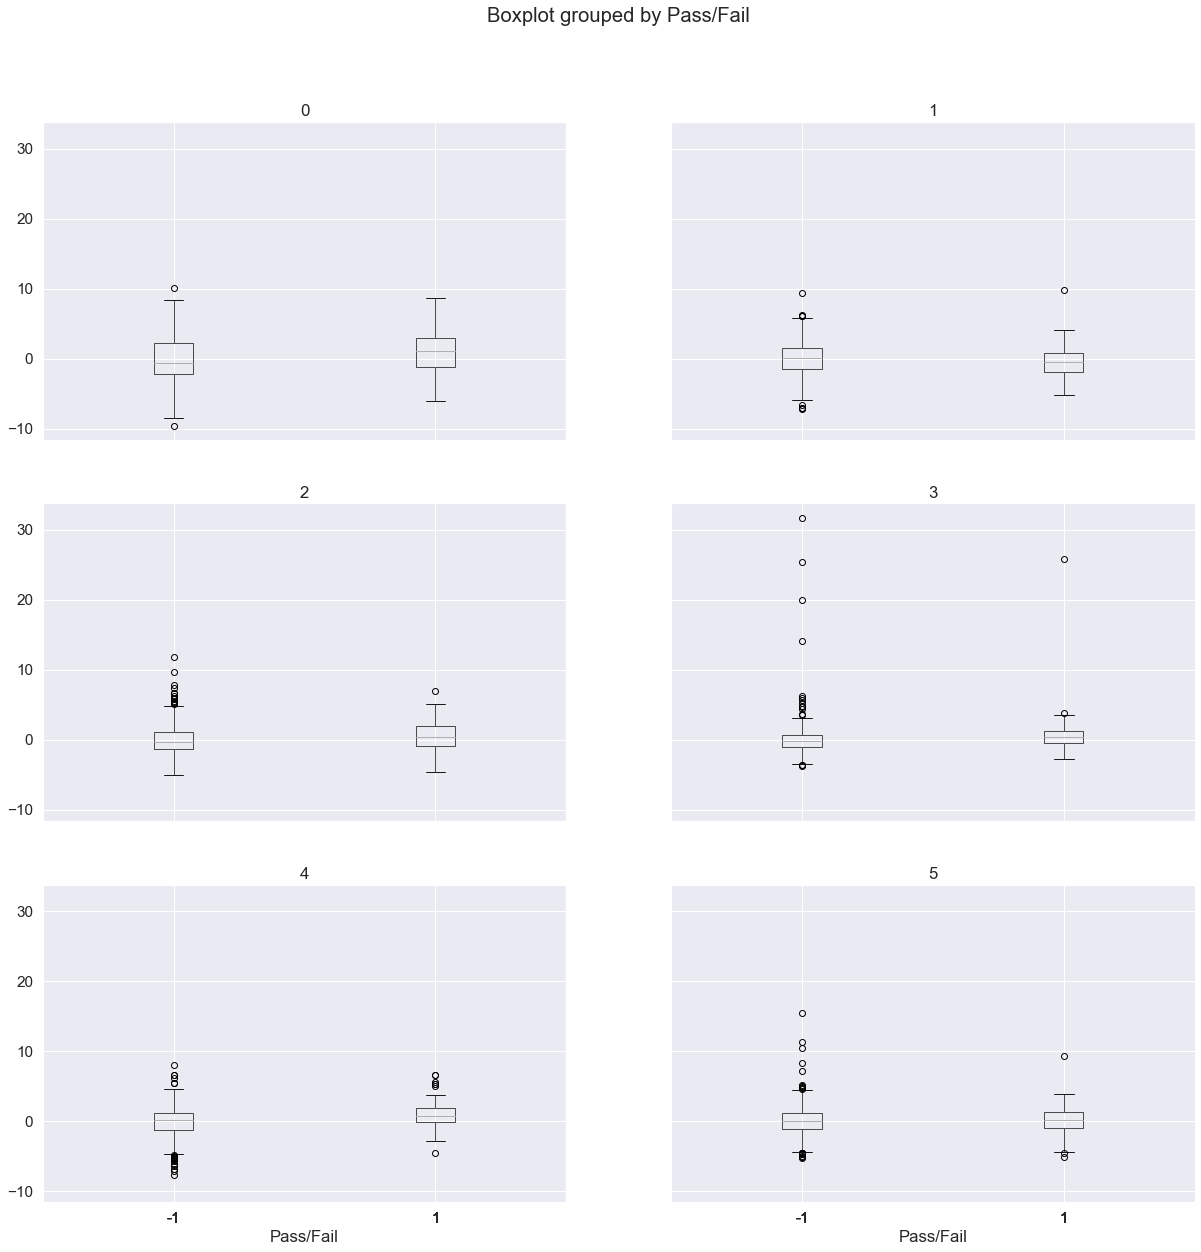

In [101]:
#Sample boxplot shows that there are outliers in the data, let us fix them
df_red4.boxplot(column = [df_red4.columns[0],
                          df_red4.columns[1],
                          df_red4.columns[2],
                          df_red4.columns[3], 
                          df_red4.columns[4],
                          df_red4.columns[5],
                         ]
                          , by = 'Pass/Fail', figsize=(20,20))

In [102]:
#Create a copy of the dataset for maintain data after outlier removal
#Here after identifying outliers we replace with median
pd_data = df_red4.copy()
#pd_data.head()

#pd_data2 = pd_data.drop(columns=['name'],axis=1)
#pd_data2 = pd_data2.apply(replace,axis=1)
from scipy import stats

#Define a function to remove outliers on max side
def outlier_removal_max(var):
    var = np.where(var > var.quantile(0.75)+ stats.iqr(var),var.quantile(0.50),var)
    return var

#Define a function to remove outliers on min side
def outlier_removal_min(var):
    var = np.where(var < var.quantile(0.25) - stats.iqr(var),var.quantile(0.50),var)
    return var

#Loop over the columns and remove the outliers on min and max side
for column in pd_data:
    pd_data[column] = outlier_removal_max(pd_data[column])
    pd_data[column] = outlier_removal_min(pd_data[column])

array([[<AxesSubplot:title={'center':'0'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'1'}, xlabel='Pass/Fail'>],
       [<AxesSubplot:title={'center':'2'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'3'}, xlabel='Pass/Fail'>],
       [<AxesSubplot:title={'center':'4'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'5'}, xlabel='Pass/Fail'>]],
      dtype=object)

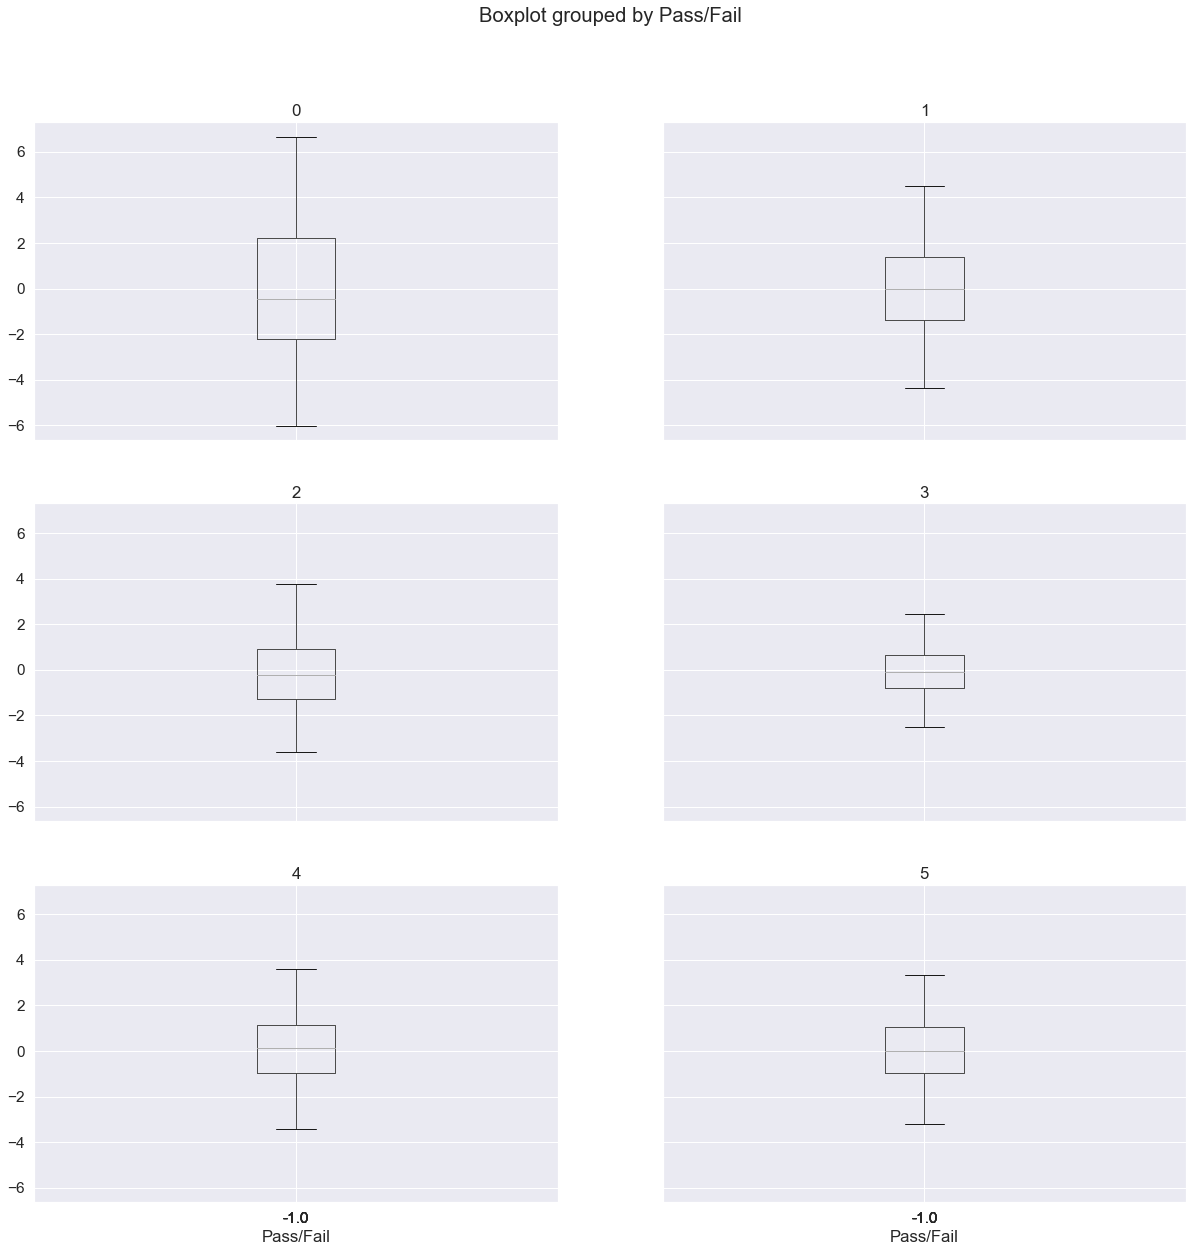

In [103]:
#Sample boxplot shows that outliers are fixed, but we are loosing observations belonging to failure 
#class (Pass/Fail = 1) So we should not remove outliers here 
pd_data.boxplot( column =[df_red4.columns[0],
                          df_red4.columns[1],
                          df_red4.columns[2],
                          df_red4.columns[3], 
                          df_red4.columns[4],
                          df_red4.columns[5],
                         ],by = 'Pass/Fail', figsize=(20,20))

In [104]:
# separating the dependent and independent data

x = df_red4.iloc[:, df_red4.columns != 'Pass/Fail'] 
y = df_red4.iloc[:, df_red4.columns == 'Pass/Fail']

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 130)
shape of y: (1567, 1)


In [105]:
# Under Sampling - Check how many failure observations are there
# We have 104 such observations

failed_tests = np.array(df_red4[df_red4['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

104


In [106]:
# Check how many pass observations are there
# We have 1,463 such observations

normal_indices = df_red4[df_red4['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

1463


In [107]:
# Get 104 random observations from the pass class as well

random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

104


In [108]:
#Getting a 50-50 representation from both pass and fail classes
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [109]:
# creating the undersample data

undersample_data = df_red4.iloc[under_sample, :]

# splitting the undersample dataset into x and y sets

x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 130)
(208, 1)


In [110]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 130)
(145, 1)
(63, 130)
(63, 1)


### XGBoost - PCA (undersampled)

In [111]:
model = XGBClassifier(random_state=1)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

cm = confusion_matrix(y_test_us, y_pred)

C:\Users\udhay\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:57:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Confusion matrix for XG Boost - PCA - (Undersampled)

<AxesSubplot:>

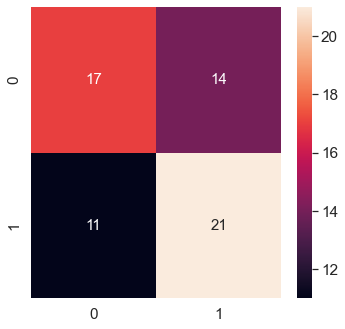

In [112]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [113]:
print("Accuracy: ", model.score(x_test_us,y_test_us)*100)

Accuracy:  60.317460317460316


### XG Boost - PCA - Grid Search - Undersampled

In [114]:
# Applying Grid Search CV to find the best model with the best parameters



parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
             'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: ", best_accuracy*100)
print("Best Parameter: ", best_parameters)

C:\Users\udhay\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:58:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:58:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Accuracy:  60.0
Best Parameter:  {'cv': 2, 'max_depth': 4, 'random_state': 1}


In [115]:
weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

print("Accuracy: ", model.score(x_test_us,y_test_us)*100)

[21:58:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:58:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  58.730158730158735


#### Confusion matrix of XG Boost - Grid Search - PCA - Undersampled

<AxesSubplot:>

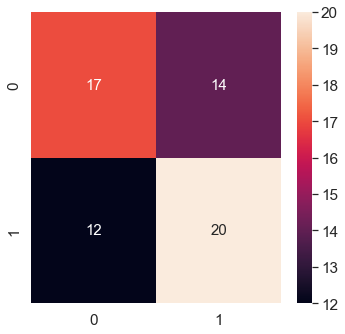

In [116]:
cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

#### Random Forest - PCA - Undersampled

In [117]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_us, y_train_us)
#scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test_us)

# evaluating the model

# printing the confusion matrix
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow'

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_17160/3162107522.py, line 10)

In [118]:
print("Accuracy: ", model.score(x_test_us,y_test_us)*100)

Accuracy:  58.730158730158735


### Logistic Regression - PCA - Undersampled

C:\Users\udhay\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<AxesSubplot:>

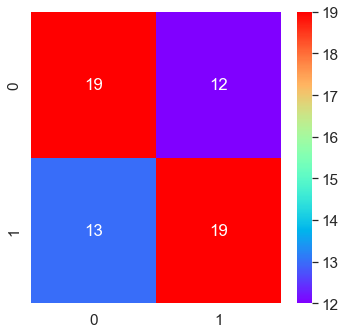

In [119]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_us, y_train_us) 
y_pred = lr.predict(x_test_us)
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [120]:
print("Accuracy: ", lr.score(x_test_us,y_test_us)*100)

Accuracy:  60.317460317460316


### Lasso - PCA - Undersampled

In [121]:
lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train_us,y_train_us)
#print ("Lasso model:", (lasso.coef_))

y_pred = lasso.predict(x_test_us)

#Convert the sign of the predicted values as the classifier
y_pred2 = np.sign(y_pred)

In [122]:
actual_cost = list(y_test_us)
actual_cost = np.asarray(actual_cost)
y_pred_lass = lasso.predict(x_test_us)

In [123]:
print("Accuracy: ", lasso.score(x_test_us, y_test_us)*100)

Accuracy:  -2.3299214988654837


### Confusion Matrix for Lasso - PCA - Undersampled

<AxesSubplot:>

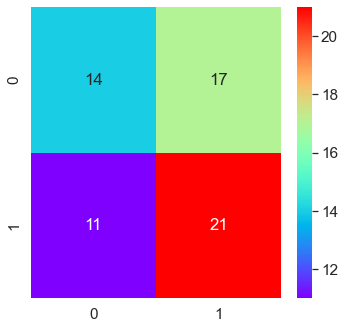

In [124]:
cm = confusion_matrix(y_test_us, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

### Elliptic Envelop technique

In [125]:
# defining outlier fraction for Elliptic Envelop, Isolation Forest and Local Outlier Factor

Fraud = data[data['Pass/Fail']==1]
Valid = data[data['Pass/Fail']==-1]

outlier_fraction = len(Fraud)/float(len(Valid))
print("Outlier Fraction :", outlier_fraction)

Outlier Fraction : 0.0710868079289132


In [126]:
from sklearn.covariance import EllipticEnvelope
model = EllipticEnvelope(contamination=outlier_fraction, random_state=1)
model.fit(x_train, y_train)
#scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test)

C:\Users\udhay\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


<AxesSubplot:>

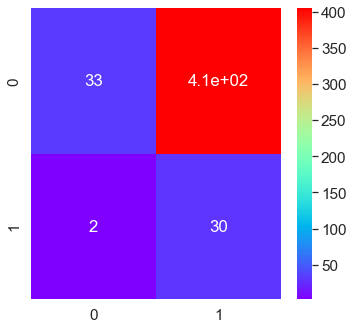

In [127]:
# printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

### Local Outlier Factor Technique

In [128]:
from sklearn.neighbors import LocalOutlierFactor


model = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, 
                           metric_params=None, contamination=outlier_fraction)

model.fit(x_train, y_train)
y_pred = model.fit_predict(x_test)

<AxesSubplot:>

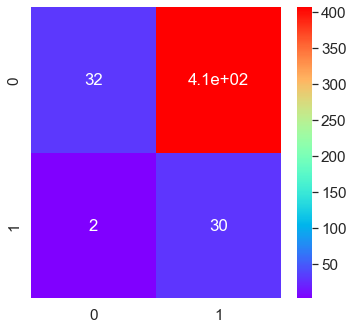

In [129]:
# printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

### Comparison of All Algorithms' Recall Rate

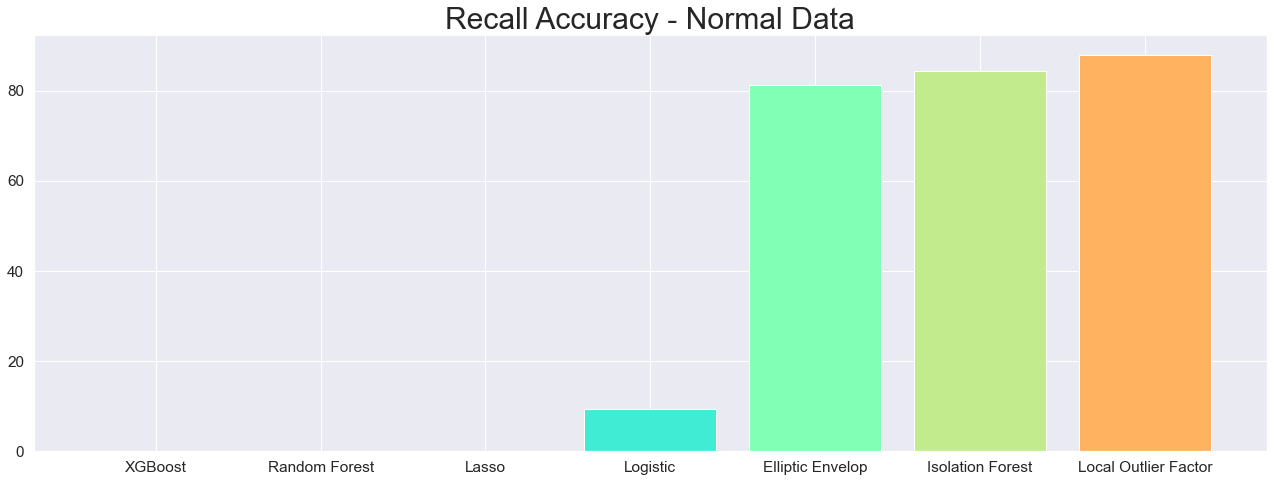

In [130]:
Recall = np.array([84.4, 87.9, 81.3,9.4,0,0,0])
label = np.array(['Isolation Forest', 'Local Outlier Factor', 'Elliptic Envelop',
                  'Logistic','XGBoost','Random Forest','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - Normal Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

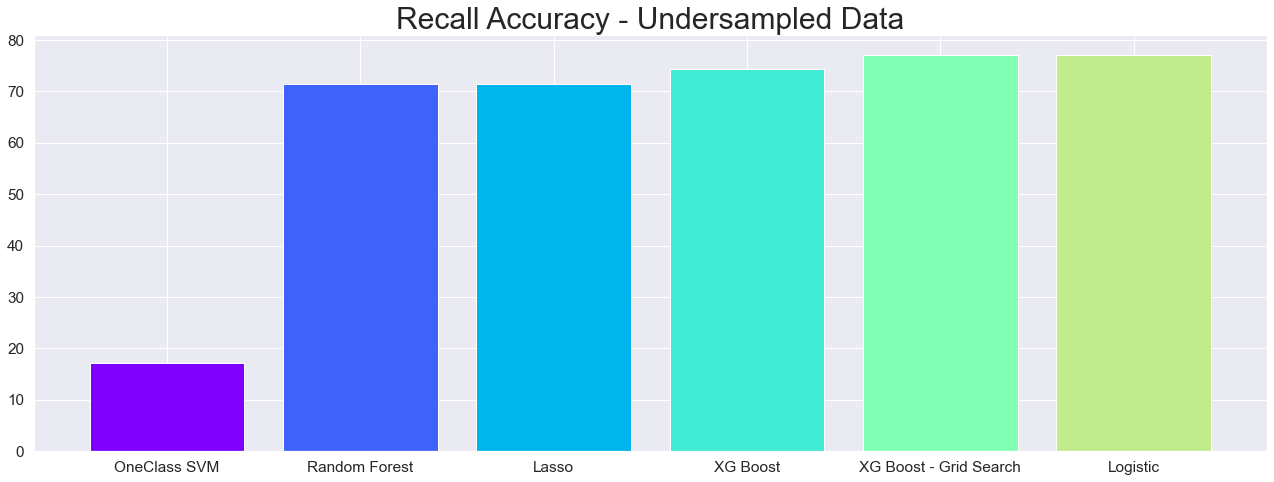

In [131]:
Recall = np.array([74.3,77.1,71.4,77.1,71.4,17.1])
label = np.array(['XG Boost','XG Boost - Grid Search','Random Forest','Logistic','Lasso','OneClass SVM'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - Undersampled Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

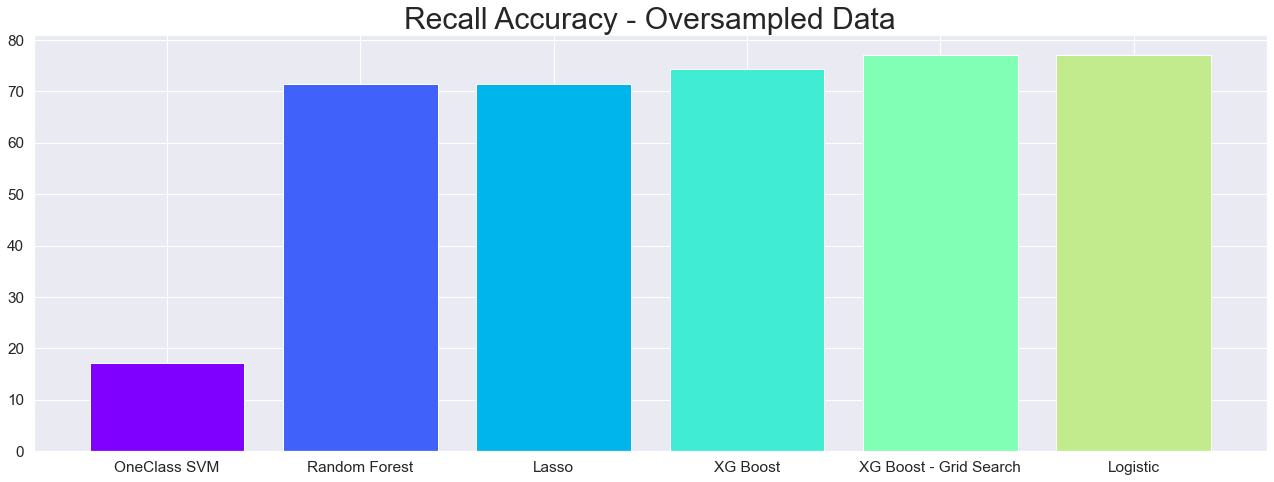

In [132]:
Recall = np.array([74.3,77.1,71.4,77.1,71.4,17.1])
label = np.array(['XG Boost','XG Boost - Grid Search','Random Forest','Logistic','Lasso','OneClass SVM'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - Oversampled Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

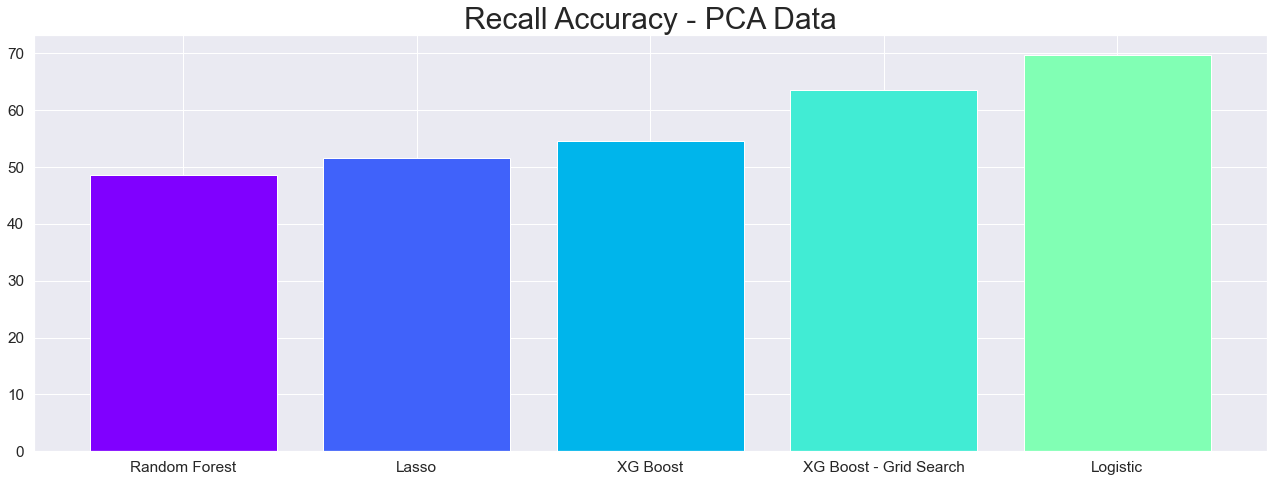

In [133]:
Recall = np.array([54.5,63.6,48.5,69.7,51.5])
label = np.array(['XG Boost','XG Boost - Grid Search','Random Forest','Logistic','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - PCA Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

C:\Users\udhay\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\udhay\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:58:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<Figure size 8000x8000 with 0 Axes>

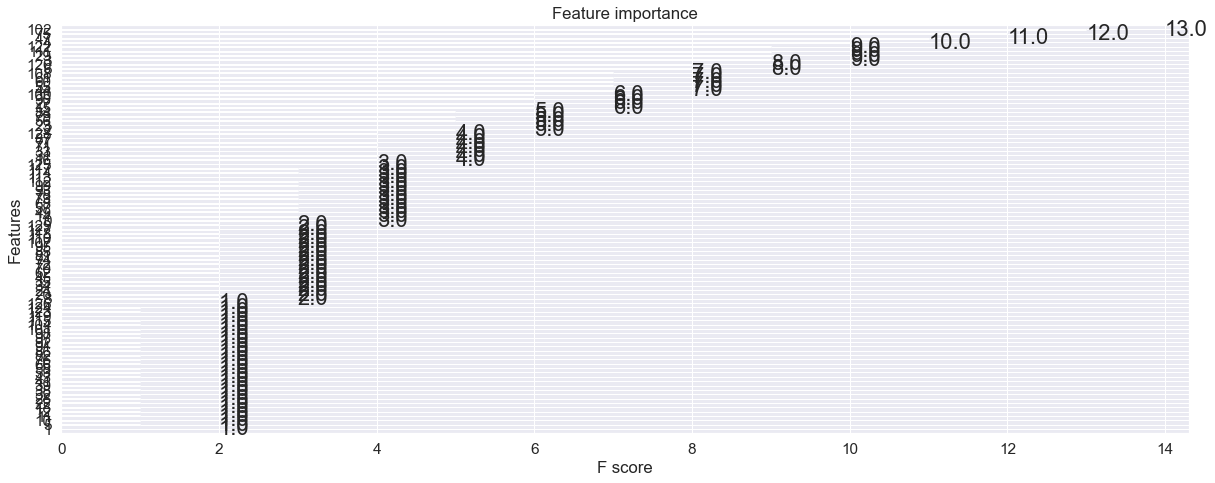

In [134]:
# plotting the feature importances

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
pyplot.rcParams.update({'font.size': 22})
from matplotlib.pyplot import figure
figure(num=None, figsize=(100, 100), dpi=80, facecolor='w', edgecolor='k')
# fit model no training data
model = XGBClassifier()
model.fit(x_train_us, y_train_us)
# plot feature importance
plot_importance(model)
pyplot.show()

In [135]:
featureImp = []
for feat, importance in zip(data.columns, model.feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
print (fT_df.sort_values('Importance', ascending = False))

    Feature  Importance
18       19    8.204473
32       41    6.273598
104     133    3.979051
123     158    3.275460
101     129    2.725279
..      ...         ...
51       67    0.000000
105     134    0.000000
106     135    0.000000
50       64    0.000000
65       83    0.000000

[130 rows x 2 columns]


We have tried multiple models Logistic Regression, Random Forest, XG Boost (with and without Grid Search),OneClassSVM, Elliptic Envelop, Isolation Forest and Local Outlier Factor for the imbalanced classes

Across methods OneClassSVM performed the worst while Local Outlier Factor performed the best in terms of recall accuracy

We saw that for imbalanced classes accuracy and recall are invertially proportional to each other. Better recall models have lower accuracy and vice versa.

We have tried two sampling techniques -first one using SMOTE (oversampling) and second one using random based method (undersampling), Oversampling gave better results than undersampling in terms of accuracy. Recall score was similar for both undersampling and oversampling.

We did Z score scaling on both the datasets and took PCA with n_components as 130 (90% variance coverage). However PCA did not improve either accuracy or recall probably as we were loosing information due to dropping dimensions